In [325]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 4)

In [326]:
inputdata1 = "../output_mo/combined_mo_data/"
inputdata2 = "../output_qt/combined_qt_data/" #jsut to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [327]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [328]:
def y_data():
    y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly.csv", index_col=0)['gdp_total'].to_frame()

    first_date = y_data.index[0]
    y_data.index = pd.PeriodIndex(y_data.index, freq='Q')
    y_data['Date'] = y_data.index.to_timestamp()

    # convert to period
    y_data['Date'] = pd.to_datetime(y_data['Date']).dt.to_period('M')
    # set Date as index and resample
    y_data = y_data.set_index('Date').resample('M').interpolate()

    y_data.index = y_data.index.strftime('%Y-%m-%d')
    y_data.index = pd.date_range(first_date, y_data.index[-1], freq='MS').date
    return y_data

In [329]:
regressionData = y_data().merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")
df = regressionData.iloc[0:355,:].copy()

<Axes: >

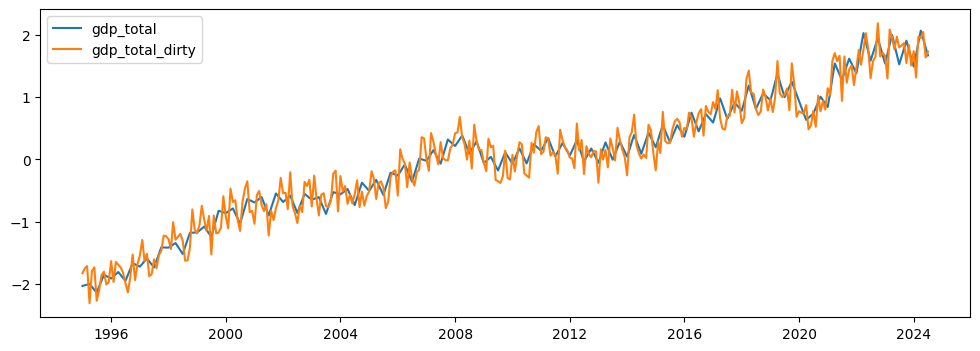

In [330]:
from sklearn.preprocessing import StandardScaler
import random


# subset of the data
df1 = df[['gdp_total', 
          '^AEX', 
          'EconomischeSituatieKomende12Maanden_5',
          'ProducerConfidence_1', 
          'Consumentenvertrouwen_1',
          'Crude oil, Brent', 
          'Coffee, Arabica', 
          'Gold', 
          'M3_1', 
          'M3_2',
          'CCICP_NLD_CLI', 
          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
          'Bankruptcies', 
          'FinancieleSituatieKomende12Maanden_7', 
          'Natural gas, Europe', 
          'CCICP_DEU', 
          'United States_unemply_M', 
          'Coconut oil',
          'BigBusinessInterestRate'
        ]]

# create a sure-fire predictor
df1['gdp_total_dirty'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# scale data to make comparable
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)

scaled_features_df[['gdp_total','gdp_total_dirty']].plot()


In [331]:
scaled_features_df.head()

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Netherlands_unemply_F,Netherlands_unemply_M,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,BigBusinessInterestRate,gdp_total_dirty
1995-01-01,-2.028624,-1.777491,0.460059,0.796119,0.283872,-1.295229,0.447421,-1.019448,-1.621328,-1.665018,...,2.294188,1.032212,-0.197557,0.023051,-0.688984,-0.071206,0.433027,-0.776979,NaN,-1.825478
1995-02-01,-2.018752,-1.779647,0.725190,0.796119,0.550353,-1.281242,0.396151,-1.022687,-1.611303,-1.654293,...,2.600233,1.227644,-0.453562,0.323345,-0.688984,-0.118037,0.234800,-0.744028,NaN,-1.742862
1995-03-01,-2.008880,-1.825242,0.824614,0.729277,0.728007,-1.283418,0.570632,-1.013394,-1.618668,-1.662577,...,2.651241,1.292788,0.016480,0.473492,-0.690267,-0.036155,0.086131,-0.753442,NaN,-1.712477
1995-04-01,-1.999008,-1.797409,0.625766,0.796119,0.683594,-1.231820,0.479659,-0.998285,-1.619225,-1.663768,...,2.345196,1.032212,-0.348642,0.473492,-0.682569,0.048682,-0.012982,-0.784040,NaN,-2.307547
1995-05-01,-2.044738,-1.737717,0.658907,0.729277,0.728007,-1.240834,0.418299,-1.008137,-1.602799,-1.646114,...,2.447211,0.836780,-0.495530,0.398418,-0.682569,0.101385,-0.062539,-0.791101,NaN,-1.793075


[ 2  4  7 10 16 19]
['ProducerConfidence_1', 'Crude oil, Brent', 'M3_1', 'Netherlands_unemply_F', 'United States_unemply_M', 'gdp_total_dirty']


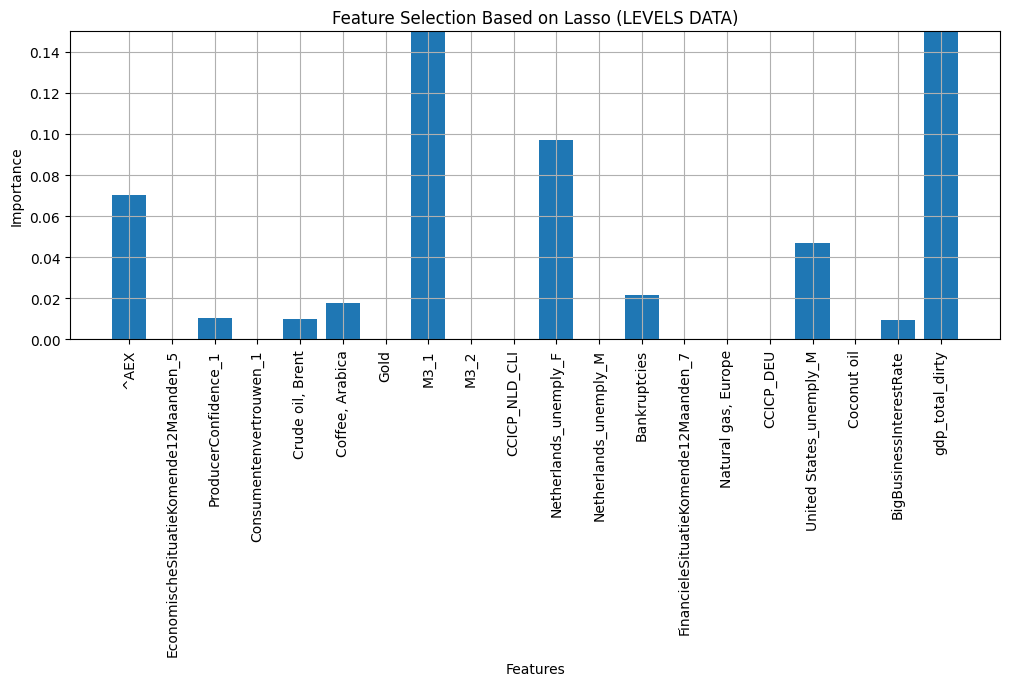

['ProducerConfidence_1',
 'Crude oil, Brent',
 'M3_1',
 'Netherlands_unemply_F',
 'United States_unemply_M',
 'gdp_total_dirty']

In [332]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables


lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

[ 2  4  5 10 13 16 17 19]
['ProducerConfidence_1', 'Crude oil, Brent', 'Coffee, Arabica', 'Netherlands_unemply_F', 'FinancieleSituatieKomende12Maanden_7', 'United States_unemply_M', 'Coconut oil', 'gdp_total_dirty']


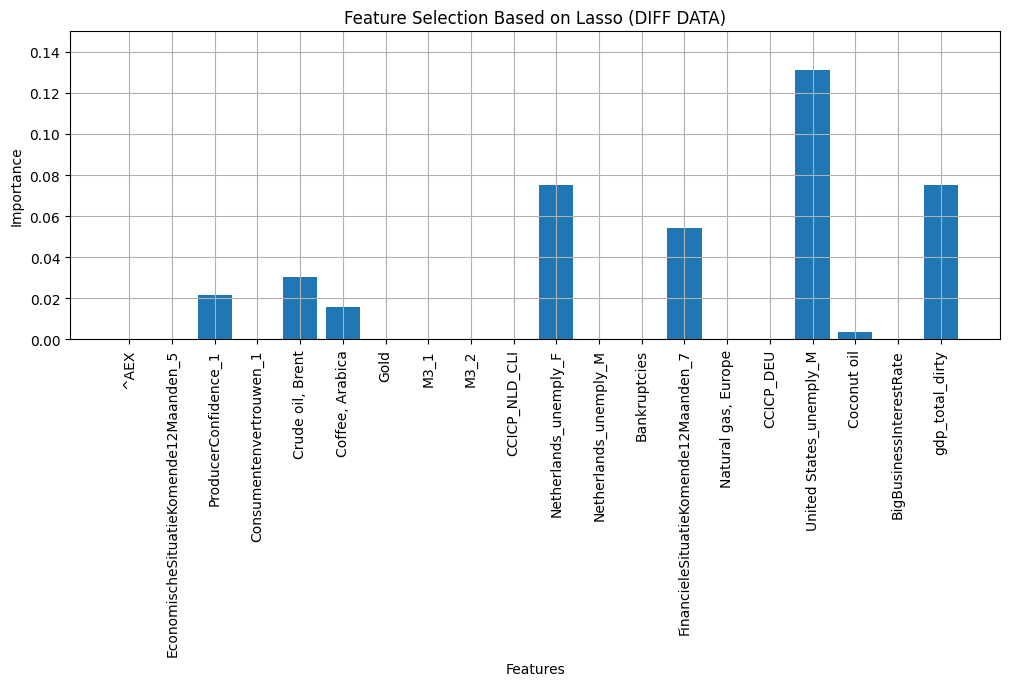

['ProducerConfidence_1',
 'Crude oil, Brent',
 'Coffee, Arabica',
 'Netherlands_unemply_F',
 'FinancieleSituatieKomende12Maanden_7',
 'United States_unemply_M',
 'Coconut oil',
 'gdp_total_dirty']

In [333]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [334]:
scaled_features_df.head()

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Netherlands_unemply_F,Netherlands_unemply_M,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,BigBusinessInterestRate,gdp_total_dirty
1995-01-01,-2.028624,-1.777491,0.460059,0.796119,0.283872,-1.295229,0.447421,-1.019448,-1.621328,-1.665018,...,2.294188,1.032212,-0.197557,0.023051,-0.688984,-0.071206,0.433027,-0.776979,NaN,-1.825478
1995-02-01,-2.018752,-1.779647,0.725190,0.796119,0.550353,-1.281242,0.396151,-1.022687,-1.611303,-1.654293,...,2.600233,1.227644,-0.453562,0.323345,-0.688984,-0.118037,0.234800,-0.744028,NaN,-1.742862
1995-03-01,-2.008880,-1.825242,0.824614,0.729277,0.728007,-1.283418,0.570632,-1.013394,-1.618668,-1.662577,...,2.651241,1.292788,0.016480,0.473492,-0.690267,-0.036155,0.086131,-0.753442,NaN,-1.712477
1995-04-01,-1.999008,-1.797409,0.625766,0.796119,0.683594,-1.231820,0.479659,-0.998285,-1.619225,-1.663768,...,2.345196,1.032212,-0.348642,0.473492,-0.682569,0.048682,-0.012982,-0.784040,NaN,-2.307547
1995-05-01,-2.044738,-1.737717,0.658907,0.729277,0.728007,-1.240834,0.418299,-1.008137,-1.602799,-1.646114,...,2.447211,0.836780,-0.495530,0.398418,-0.682569,0.101385,-0.062539,-0.791101,NaN,-1.793075


In [335]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty'] + selectThese 
df_lag = df[selectThese]

[ 0  1  2  9 21]
['gdp_total_dirty', 'gdp_total_lag_1', '^AEX_lag_1', 'M3_1_lag_1', 'gdp_total_dirty_lag_1']


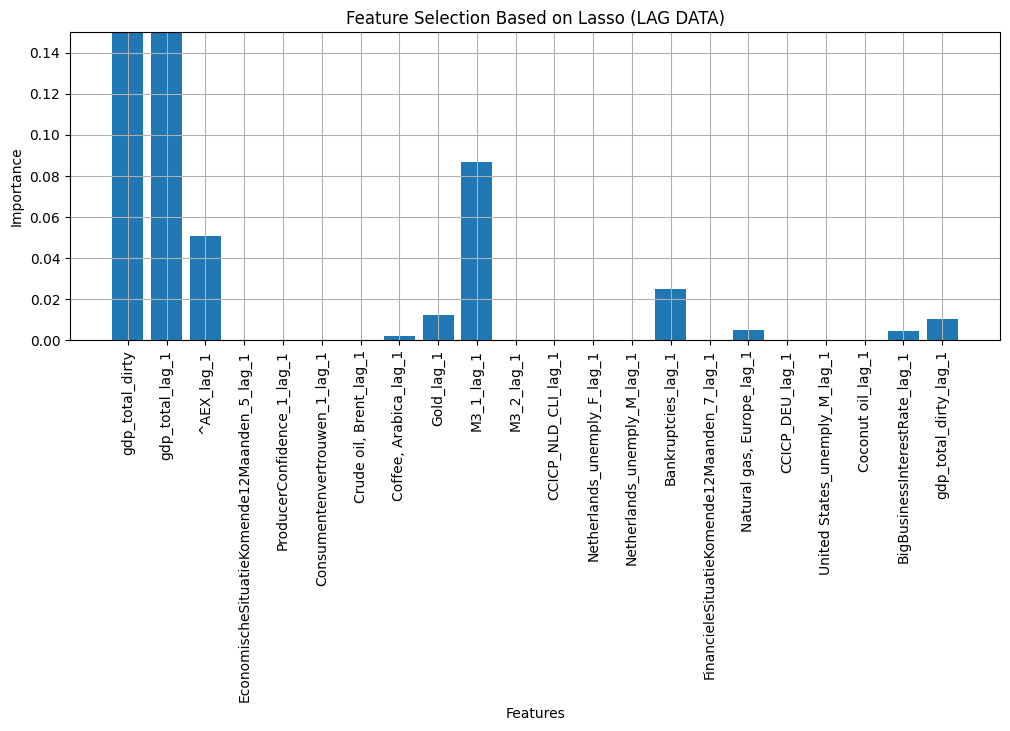

['gdp_total_dirty',
 'gdp_total_lag_1',
 '^AEX_lag_1',
 'M3_1_lag_1',
 'gdp_total_dirty_lag_1']

In [336]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  3  6 12 13 14 16 19 20 21]
['gdp_total_dirty', 'gdp_total_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'Crude oil, Brent_lag_1', 'Netherlands_unemply_F_lag_1', 'Netherlands_unemply_M_lag_1', 'Bankruptcies_lag_1', 'Natural gas, Europe_lag_1', 'Coconut oil_lag_1', 'BigBusinessInterestRate_lag_1', 'gdp_total_dirty_lag_1']


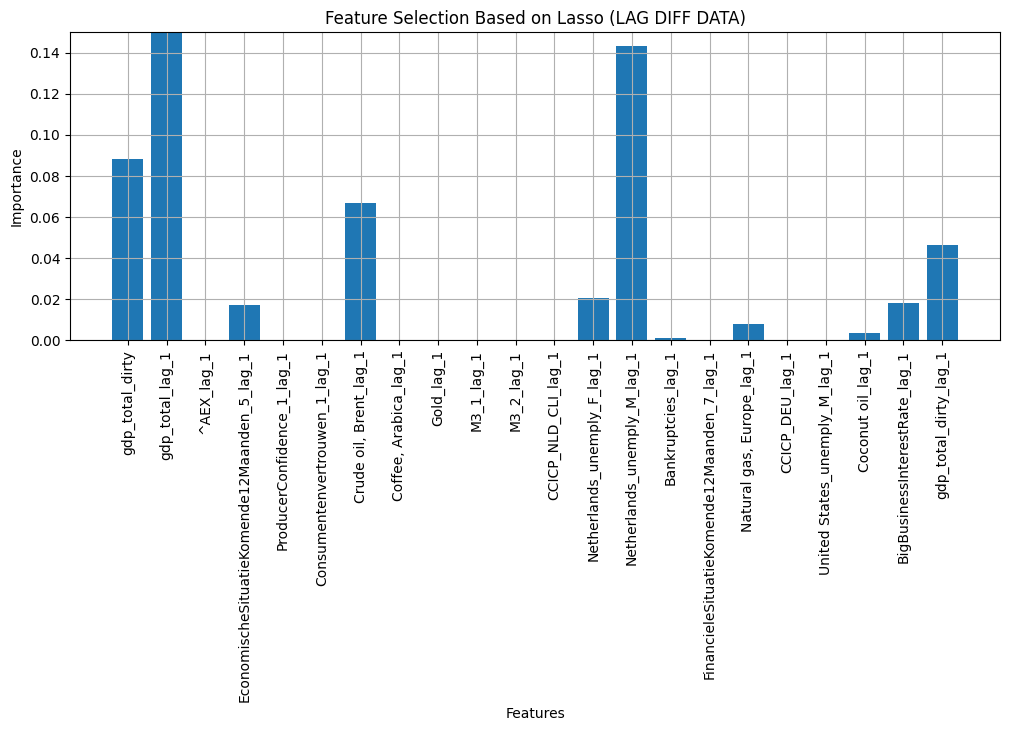

['gdp_total_dirty',
 'gdp_total_lag_1',
 'EconomischeSituatieKomende12Maanden_5_lag_1',
 'Crude oil, Brent_lag_1',
 'Netherlands_unemply_F_lag_1',
 'Netherlands_unemply_M_lag_1',
 'Bankruptcies_lag_1',
 'Natural gas, Europe_lag_1',
 'Coconut oil_lag_1',
 'BigBusinessInterestRate_lag_1',
 'gdp_total_dirty_lag_1']

In [337]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 

### Make sure data is stationary

<Axes: >

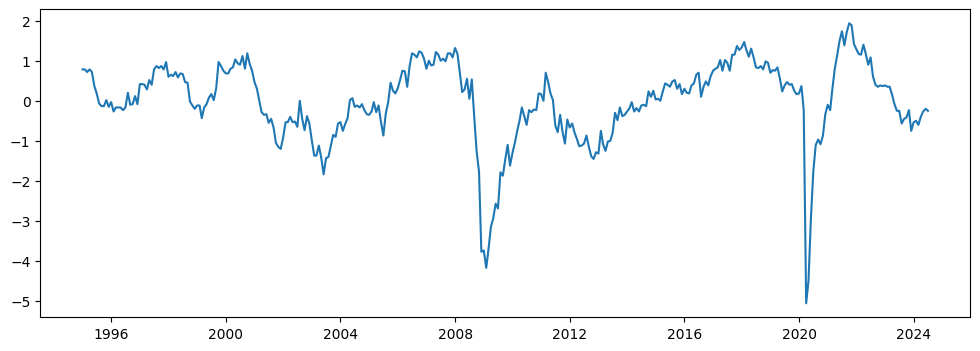

In [338]:
scaled_features_df['ProducerConfidence_1'].plot()

In [339]:
timeseries = scaled_features_df['ProducerConfidence_1']

In [340]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [341]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [342]:
def stationdarydf(mydata, save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
        else:
            stationary_features.append('NotStationary')
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df

#stationdarydf(scaled_features_df)

### If not stationary, difference, then test for stationarity again

replace in original data frame

In [343]:

def differenceData(originalData, mydiff=1):
    
    ## which features are not stationary
    # function from above
    stat1 = stationdarydf(originalData)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in stationarydf_diff:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        stationarydf_diff.rename(columns={col: col + "_diff"}, inplace=True)
    

    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff

scaled_features_df_diff = differenceData(scaled_features_df, mydiff=1)

In [344]:
stationdarydf(scaled_features_df_diff, save = 'False')

,Feature,Stationary,Length
0,gdp_total_diff,Stationary,354
1,^AEX_diff,Stationary,354
2,EconomischeSituatieKomende12Maanden_5,Stationary,354
3,ProducerConfidence_1,Stationary,354
4,Consumentenvertrouwen_1_diff,Stationary,354
5,"Crude oil, Brent_diff",Stationary,354
6,"Coffee, Arabica_diff",Stationary,354
7,Gold_diff,Stationary,354
8,M3_1_diff,Stationary,354
9,M3_2_diff,Stationary,354


<Axes: >

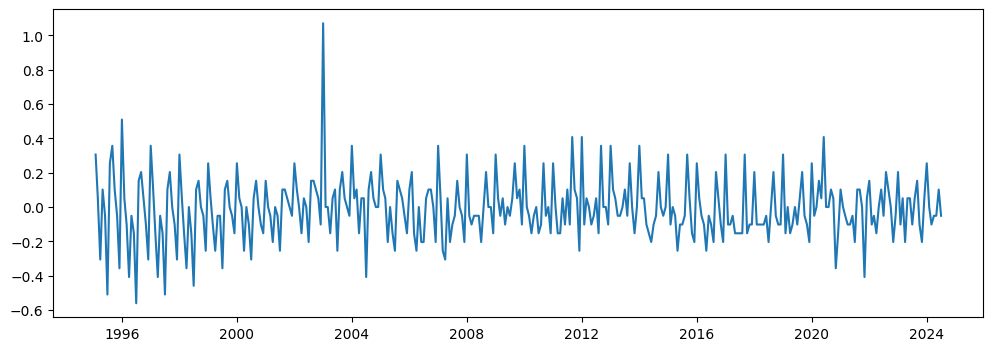

In [345]:
scaled_features_df_diff['Netherlands_unemply_F_diff'].plot()

[ 2  4  5 10 13 16 17 19]
['ProducerConfidence_1', 'Crude oil, Brent_diff', 'Coffee, Arabica_diff', 'Netherlands_unemply_F_diff', 'FinancieleSituatieKomende12Maanden_7_diff', 'United States_unemply_M_diff', 'Coconut oil_diff', 'gdp_total_dirty_diff']


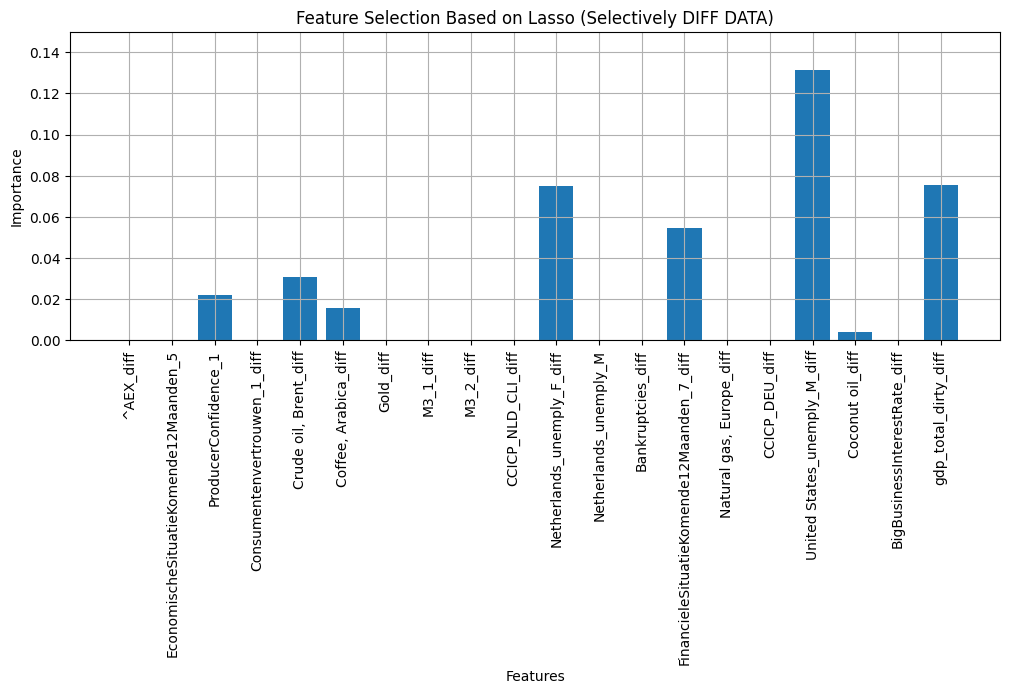

['ProducerConfidence_1',
 'Crude oil, Brent_diff',
 'Coffee, Arabica_diff',
 'Netherlands_unemply_F_diff',
 'FinancieleSituatieKomende12Maanden_7_diff',
 'United States_unemply_M_diff',
 'Coconut oil_diff',
 'gdp_total_dirty_diff']

In [347]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

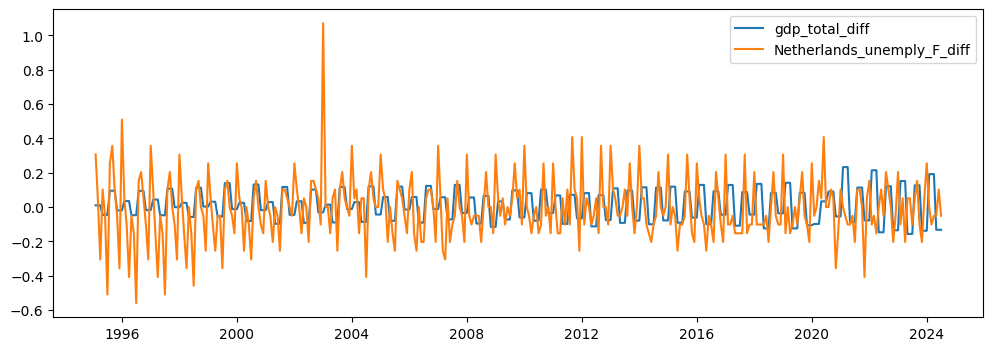

In [350]:
scaled_features_df_diff[['gdp_total_diff', 'Netherlands_unemply_F_diff']].plot()

In [354]:

df_lag_diff = differenceData(df_lag, mydiff=1)
stationdarydf(df_lag_diff, save = 'False')

,Feature,Stationary,Length
0,gdp_total_diff,Stationary,354
1,gdp_total_dirty_diff,Stationary,354
2,gdp_total_lag_1_diff,Stationary,353
3,^AEX_lag_1_diff,Stationary,353
4,EconomischeSituatieKomende12Maanden_5_lag_1,Stationary,353
5,ProducerConfidence_1_lag_1,Stationary,353
6,Consumentenvertrouwen_1_lag_1_diff,Stationary,353
7,"Crude oil, Brent_lag_1_diff",Stationary,353
8,"Coffee, Arabica_lag_1_diff",Stationary,353
9,Gold_lag_1_diff,Stationary,353


[ 0  1  3  6 12 13 14 16 19 20 21]
['gdp_total_dirty_diff', 'gdp_total_lag_1_diff', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'Crude oil, Brent_lag_1_diff', 'Netherlands_unemply_F_lag_1_diff', 'Netherlands_unemply_M_lag_1', 'Bankruptcies_lag_1_diff', 'Natural gas, Europe_lag_1_diff', 'Coconut oil_lag_1_diff', 'BigBusinessInterestRate_lag_1_diff', 'gdp_total_dirty_lag_1_diff']


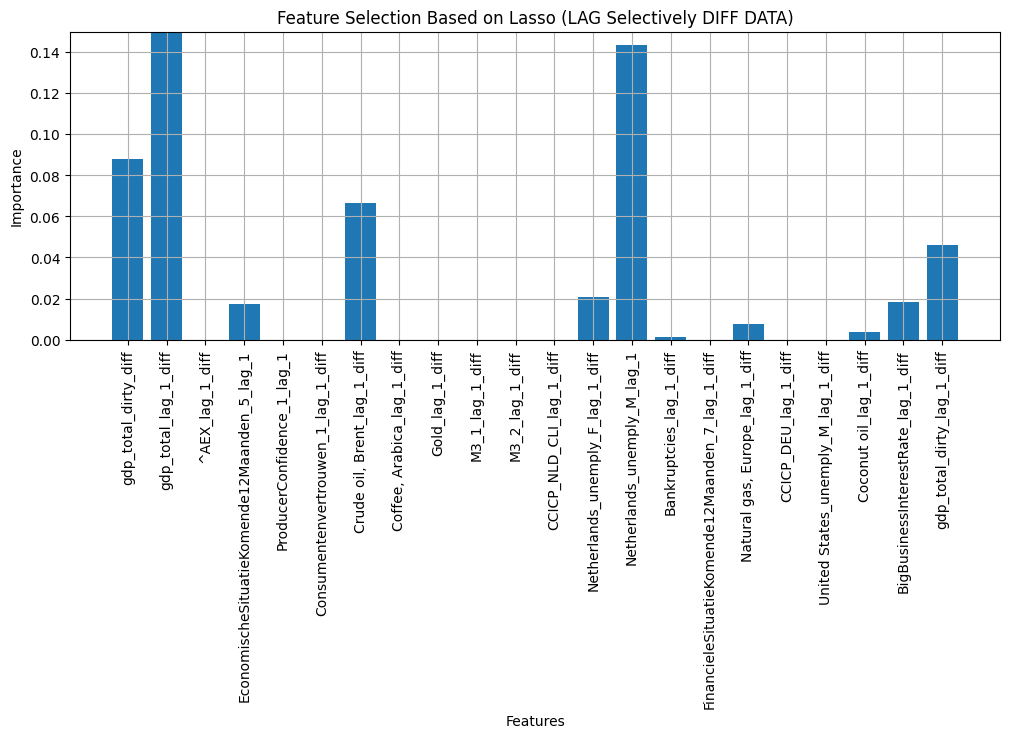

['gdp_total_dirty_diff',
 'gdp_total_lag_1_diff',
 'EconomischeSituatieKomende12Maanden_5_lag_1',
 'Crude oil, Brent_lag_1_diff',
 'Netherlands_unemply_F_lag_1_diff',
 'Netherlands_unemply_M_lag_1',
 'Bankruptcies_lag_1_diff',
 'Natural gas, Europe_lag_1_diff',
 'Coconut oil_lag_1_diff',
 'BigBusinessInterestRate_lag_1_diff',
 'gdp_total_dirty_lag_1_diff']

In [355]:
lassoreg(df_lag_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG Selectively DIFF DATA)') 

In [357]:
df_lag_diff

,gdp_total_diff,gdp_total_dirty_diff,gdp_total_lag_1_diff,^AEX_lag_1_diff,EconomischeSituatieKomende12Maanden_5_lag_1,ProducerConfidence_1_lag_1,Consumentenvertrouwen_1_lag_1_diff,"Crude oil, Brent_lag_1_diff","Coffee, Arabica_lag_1_diff",Gold_lag_1_diff,...,Netherlands_unemply_F_lag_1_diff,Netherlands_unemply_M_lag_1,Bankruptcies_lag_1_diff,FinancieleSituatieKomende12Maanden_7_lag_1_diff,"Natural gas, Europe_lag_1_diff",CCICP_DEU_lag_1_diff,United States_unemply_M_lag_1_diff,Coconut oil_lag_1_diff,BigBusinessInterestRate_lag_1_diff,gdp_total_dirty_lag_1_diff
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-01,0.009872,0.082615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-01,0.009872,0.030386,0.009872,-0.002156,0.265131,0.000000,0.266482,0.013987,-0.051270,-0.003239,...,0.306045,0.195432,-0.256005,0.300294,0.000000,-0.046831,-0.198226,0.032951,NaN,0.082615
1995-04-01,0.009872,-0.595070,0.009872,-0.045594,0.099424,-0.066841,0.177654,-0.002176,0.174481,0.009293,...,0.051008,0.065144,0.470042,0.150147,-0.001283,0.081882,-0.148670,-0.009415,NaN,0.030386
1995-05-01,-0.045730,0.514472,0.009872,0.027833,-0.198849,0.066841,-0.044414,0.051598,-0.090973,0.015109,...,-0.306045,-0.260576,-0.365122,0.000000,0.007699,0.084837,-0.099113,-0.030598,NaN,-0.595070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.191873,0.652736,0.191873,0.353628,-0.198849,0.033421,0.044414,0.109940,0.106339,-0.018314,...,0.000000,0.130288,-0.520403,0.000000,-0.181075,0.158626,-0.099113,0.096524,-0.040689,-0.421293
2024-04-01,0.191873,-0.020331,0.191873,0.122973,-0.033141,-0.100262,0.222068,0.052313,0.001808,0.228537,...,-0.102015,-0.130288,-0.020984,0.150147,0.052010,0.232923,-0.148670,0.273684,0.301096,0.652736
2024-05-01,-0.132503,0.096107,0.191873,0.087919,-0.066283,0.200524,0.044414,0.143199,0.549056,0.294112,...,-0.051008,-0.065144,0.344138,0.075074,0.068183,0.261002,-0.198226,0.323323,-0.146479,-0.020331
2024-06-01,-0.132503,-0.409191,-0.132503,0.185764,-0.132566,0.133683,-0.044414,-0.250498,-0.156796,0.033372,...,-0.051008,0.000000,-0.352531,-0.075074,0.133179,0.167010,0.148670,-0.055288,-0.154617,0.096107
